# Tyre Modelling

Pacejka '96 model, often referred as the magic formula. It is known as a semi-empirical formula which means that it is partly based on theoretical considerations, but is populated by coefficients derived from real experimental tests. 
The following theory was extracted from the book: `Race Car Design, Derek Seward, pages 131-133`.

The technique is based upon an equation that defines the shape of the relevant curve at a particular value of vertical load known as the nominal wheel load, $Fz_0$

$$F_y = D_ySin[C_y*tan^{-1}(B_y\alpha_y - E_y(B_y\alpha_y - tan^{-1}(B_y\alpha_y)))] + S_Vy $$


In the above:

$ D_y $ is the peak value and is related to the friction coefficient:

$$D_Y = F_z*(p_{DY1} + p_{DY2}*df_Z)*(1-p_{DY3}*\gamma_y^2)*\lambda_{uy}$$

Where $F_z$ = actual vertical wheel load (input in N)

$p_{CY1}...p_{VY4}$ = Pacejka coefficients obtained from the tyre test data ( 18 such coefficients are required for lateral grip)

$df_Z$ = normalized change in vertical load = $\frac{F_Z - F_{Z0}}{F_{Z0}}$

$\gamma_y$ = actual wheel camber (input in radians) 

$\lambda_{uy}$ = user scaling factor on the friction coefficient

Several such '$\lambda$' scaling factors are available to enable user to adapt the formula for track conditions that differ from the test conditions. Generally the value is set to 1, however the above $\lambda_{uy}$ factor is particularly useful if the track surface is not as 'grippy' as the grit-paper used on the test rolling road.

$C_y$ is the shape factor which together with the curvature factor, $E_y$, determines the appearance of the curve in the region of the peak. In this context 'shape' refers to the sahpe of the curve, not the tyre.

$$C_y = p_{CY1}*\lambda_{CY}$$

$B_y$ is the stiffness factor and together with $C_y$ and $D_y$ determines the slope of the curve near the origin.

$$B_y = \frac{P_{Ky1}F_{Z0}[2*tan^{-1}(\frac{F_Z}{P_{ky2}F_{Z0}\lambda_{Z0}})](1-P_{Ky3})|\gamma|)\lambda_{FZ0}\lambda_{Kya}}{C_y*D_y}$$

and    $\alpha_y = \alpha + S_{Hy}$
       $\alpha$ = actual slip angle (input in radians)

$S_{Hy}$ is a term quantifying the horizontal shift of the curve at the origin:

$$S_{Hy} = (p_{HY1} + p_{HY2}df_Z + p_{HY3}\gamma_y)\lambda_{Hy}$$

$E_Y$ is the curvature factor.

$$E_y = (P_{EY1} + P_{EY2}df_Z){(1 - (P_{EY3} + P_{EY4}\gamma_y)sgn(\alpha_y))}\lambda_{Ey}$$

where sgn($\alpha_y$) takes the value of 1 if $\alpha_y$ is positive and -1 if $\alpha_y$ is negative.
$S_{Vy}$ is a term quantfying the vertical shift of the curve at the origin:

$$S_{Vy} = F_Z(P_{VY1} + P_{VY2}df_Z + (P_{VY3} + P_{VY4}df_Z)\gamma_y)\lambda_{Vy}\lambda_{Kya}$$

|Coefficient|Description|
|----|----|
|$F_{Z0}$|Nominal Load(N)|
|$P_{CY1}$|Shape Factor|
|$P_{DY1}$|Lateral Friction, $\mu_y$|
|$P_{DY2}$|Variation of friction with load|
|$P_{DY3}$|Variation of friction with camber squared|
|$P_{EY1}$|Lateral Curvature at $F_{Z0}$|
|$P_{EY2}$|Variation of curvature with load|
|$P_{EY3}$|Zero order camber dependency of curvature|
|$P_{EY4}$|Variation of curvature with camber|
|$P_{KY1}$|Maximum value of stiffness $\frac{K_y}{F_{Z0}}$|
|$P_{KY2}$|Normalised load at which $K_y$ reaches max. value|
|$P_{KY3}$|Variation of $\frac{K_y}{F_{Z0}}$ with camber|
|$P_{HY1}$|Horizontal shift $S_{Hy}$ at $F_{Z0}$|
|$P_{HY2}$|Variation of $S_{Hy}$ with load|
|$P_{HY3}$|Variation of $S_{Hy}$ with camber|
|$P_{VY1}$|Vertical shift $S_{Vy}$ at $F_{Z0}$|
|$P_{VY2}$|Variation of $S_{Vy}$ with load|
|$P_{VY3}$|Variation of $S_{Vy}$ with camber|
|$P_{VY4}$|Variation of $S_{Vy}$ with camber and load|

## Curve Fitting

The focus of this work is on the lateral behaviour of tyres, and the fitting of simplified Magic Formula (MF) equations to two sets of data:
* The first is that of cornering stiffness variation with vertical load
* The second is lateral force at the contact patch against slip angle.

We will use the function defining the cornering stiffness properties to determine the value of the cornering stiffness coefficient used in the second stage of the process. We will be using the curve fitting process to determine the five coefficients, PKY1, PKY2, PCY1, PDY1 and PEY1. 

In [1]:
# Import Libraries
#For data manipulation
import numpy as np
#For data visualization
import matplotlib.pyplot as plt
#For fitting the curve
from scipy.optimize import curve_fit
#For metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats

### Cornering stiffness variation with vertical load

A simplified version of Magic Formula’s cornering stiffness function (as a function of vertical load) can be expressed as follows: 
$$
K_{y\alpha} = {P_{Ky1}F_{Z0}Sin[2*tan^{-1}(\frac{F_Z}{P_{ky2}F_{Z0}})]}
$$

where the reference vertical load for this exercise is given as $F_{Z0}$=5000 N. The coefficients $P_{KY1}$ and $P_{KY2}$ are to be determined through the fitting process. The vertical load, $F_z$, and the measurement values of the cornering stiffness $K_{y\alpha}$ are obtained directly from the data sheet. The function above is used to describe how the cornering stiffness of the tyre changes as a function of vertical load. 

#### Calculate the optimized values

Before proceed to calculate the optimized values, we need to talk about the `curve_fit` function.
This SciPy function tries to match the function output (in this case `cornering_stiffness` function) with our inputted values (in this case $K_{y\alpha}$), by finding the best parameters (in this case `Pky1` and `Pky2`).

In [2]:
#Declaring initial values
# Vertical Force reference
Fz0 = 5000
# Pacekja coefficients, initial values
Pky1_init = 10.00
Pky2_init = 1.00
# Vertical Force
Fz = np.array([0,1000,2000,3000,4000,5000,6000,7000,8000])
# Cornering Stiffness
K_y_alpha = np.array([0.000,487.352,1122.378,1461.080,1864.081,2126.378,2136.157,2263.919,2276.822])
# Declaring function for cornering stiffness
def cornering_stiffness(Fz, Pky1, Pky2):
    '''
    This function is going to be the input for the curve_fit scipy function.
    Inputs: Fz(an array with the vertical forces)
           Pky1,Pky2(Pacejka coefficients)     
    '''
    return Pky1*Fz0*np.sin(2*np.atan(Fz/(Pky2*Fz0)))

In [3]:
# Print the data values
print(f'The lateral forces in N are: {Fz}')
print(f'The Cornering Stiffness in N/deg are: {K_y_alpha}')

The lateral forces in N are: [   0 1000 2000 3000 4000 5000 6000 7000 8000]
The Cornering Stiffness in N/deg are: [   0.     487.352 1122.378 1461.08  1864.081 2126.378 2136.157 2263.919
 2276.822]


In [4]:
opt_parameters, _ = curve_fit(cornering_stiffness, Fz, K_y_alpha, p0=[Pky1_init, Pky2_init] )
P_ky1, P_ky2 = opt_parameters

In [5]:
print(f'The optimal parameters are:\n Pky1 = {P_ky1:.4f} \n Pky2 = {P_ky2:.4f}  ')

The optimal parameters are:
 Pky1 = 0.4556 
 Pky2 = 1.5830  


#### Plot the graph

In [6]:
# Re-calculating the cornering stiffness with the optimized values
Fz_optimized = np.linspace(0,8000,100)
K_y_alpha_optimized = cornering_stiffness(Fz_optimized,P_ky1, P_ky2)

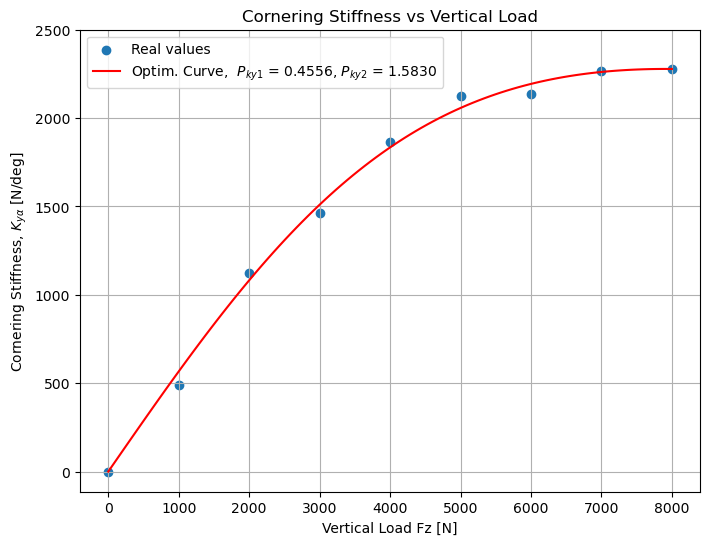

In [7]:
# Plotting the graph
plt.figure(figsize=(8,6))
plt.scatter(Fz, K_y_alpha, label='Real values')
plt.plot(Fz_optimized, K_y_alpha_optimized, 'r-', label=r'Optim. Curve,  $P_{ky1}$ = 0.4556, $P_{ky2}$ = 1.5830')
plt.xlabel("Vertical Load Fz [N]")
plt.ylabel(r'Cornering Stiffness, $K_{y\alpha}$ [N/deg]')
plt.title("Cornering Stiffness vs Vertical Load")
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0,3000,500))
plt.savefig("Cornering_stiffness_vs_vertical_load.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
#Calculate the mean squared error(MSE)
K_y_alpha_predicted = cornering_stiffness(Fz,P_ky1, P_ky2)
residuals_1 = K_y_alpha-K_y_alpha_predicted
rmse = root_mean_squared_error(K_y_alpha, K_y_alpha_predicted)
mape = mean_absolute_percentage_error(K_y_alpha, K_y_alpha_predicted)

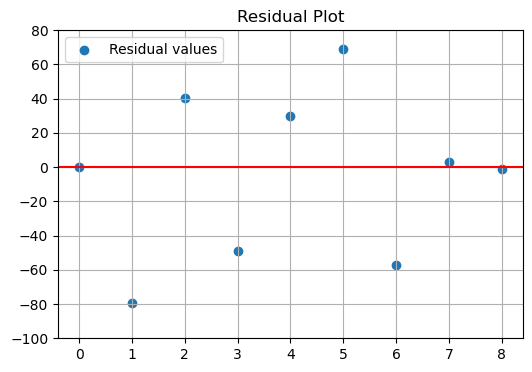

In [9]:
# Plotting the residuals
plt.figure(figsize=(6,4))
plt.scatter(np.arange(len(K_y_alpha)),residuals_1, label='Residual values')
plt.axhline(y=0, color='r')
plt.title('Residual Plot')
plt.yticks(np.arange(-100,100,20))
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig("Residual_plot_Cornering_stiffness_vs_vertical_load.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
print(f'The Root Mean Squared Error is: {rmse:.3f}')
print(f'The Mean Absolute Percentage Error is: {100*mape:.3f}%')

The Root Mean Squared Error is: 46.251
The Mean Absolute Percentage Error is: 3.434%


### Lateral Force Model

The next version of simplified Magic Formula formulation is used to describe how the lateral force output of the model, $F_y$, changes as a function of slip angle, $\alpha$: 

$$F_y = D_ySin[C_ytan^{-1}(B_ya_y - E_y(B_ya_y - tan^{-1}(B_ya_y)))] $$

where:
$$a_y = tan(\alpha) = \alpha$$

Considering the actual camber of the wheel $\gamma=0$, the scaling factors $\lambda=1$, the absence of variation of friction load $P_{DY2}$, variation of friction with camber squared $P_{DY3}$, variation of curvature with load $P_{EY2}$, Zero order camber dependency of curvature $P_{EY3}$ and variation of curvature with camber $P_{EY4}$, the model coefficients could be simplified as:

$$C_y = p_{CY1}$$

$$D_Y = F_z(p_{DY1})$$

$$B_y = \frac{K_{y\alpha}}{C_yD_y}$$

$$E_y = P_{EY1}$$

We will need to use the function derived in Stage One of the process to determine the appropriate value of $B_y$ at the specified vertical load, for our data.
The coefficients $P_{CY1}$, $P_{DY1}$ and $P_{EY1}$ are to be determined through the fitting process. 
Note that a constant vertical load of $F_Z$= 5000 N should be assumed for this stage of the exercise. 


In [11]:
#Declaring initial values
# Constant Vertical Force
Fz_constant = 5000

#Cornering stiffness at Fz=5000
K_y_alpha_const = cornering_stiffness(Fz_constant, P_ky1, P_ky2)*180/np.pi

# Pacekja coefficients, initial values
PCY1_init = 0.50
PDY1_init = 0.50
PEY1_init = 0.50

# Slip angle (from degrees to radians)
alpha_deg = np.array([0.0, 1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5, 12.0])
alpha_radians = np.radians(alpha_deg)

# Lateral force
Fy = np.array([0.000, 2599.245, 3894.138, 4036.015, 4244.155, 4064.562, 3802.260, 3877.155, 3533.645])

# Lateral force function
def lateral_force(alpha, PCY1, PDY1, PEY1, K_y_alpha_const):
    '''
    This function is going to be the input for the curve_fit scipy function.
    Inputs: Fz(an array with the lateral forces)
           Pky1,Pky2(Pacejka coefficients)     
    '''
    a_y = np.tan(alpha)
    Cy = PCY1
    Dy = Fz_constant*PDY1
    By = K_y_alpha_const/(Cy*Dy)
    Ey = PEY1
    
    return Dy*np.sin(Cy*np.atan(By*a_y-Ey*(By*a_y - np.atan(By*a_y))))

In [12]:
# Print the data values
print(f'The slip angles in radians are: {alpha_radians}')
print(f'The lateral forces in N are: {Fy}')

The slip angles in radians are: [0.         0.02617994 0.05235988 0.07853982 0.10471976 0.13089969
 0.15707963 0.18325957 0.20943951]
The lateral forces in N are: [   0.    2599.245 3894.138 4036.015 4244.155 4064.562 3802.26  3877.155
 3533.645]


In [13]:
opt_params, _ = curve_fit(lambda alpha_radians, PCY1, PDY1, PEY1 :
                          lateral_force(alpha_radians, PCY1, PDY1, PEY1, K_y_alpha_const), alpha_radians, Fy , p0=[PCY1_init, PDY1_init, PEY1_init])
p_CY1, p_DY1, p_EY1 = opt_params

In [14]:
print(f'The optimal parameters are:\n PCY1 = {p_CY1:.4f} \n PDY1 = {p_DY1:.4f} \n PEY1 = {p_EY1:.4f}  ')

The optimal parameters are:
 PCY1 = 1.8712 
 PDY1 = 0.8347 
 PEY1 = 0.5834  


In [15]:
# Re-calculating the lateral force with the optimized values
alpha_optimized = np.linspace(0,12,100)
Fy_optimized = lateral_force(np.radians(alpha_optimized),p_CY1, p_DY1, p_EY1, K_y_alpha_const)

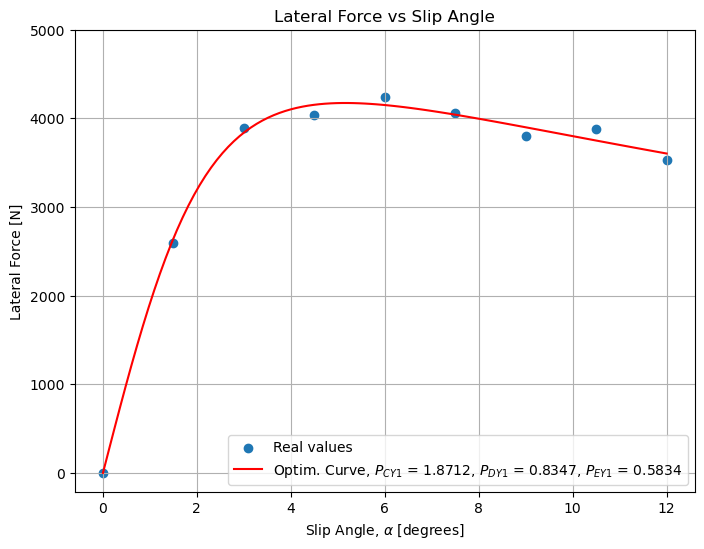

In [16]:
# Plotting the graph
plt.figure(figsize=(8,6))
plt.scatter(alpha_deg, Fy, label='Real values')
plt.plot(alpha_optimized,Fy_optimized, 'r-', label='Optim. Curve, $P_{CY1}$ = 1.8712, $P_{DY1}$ = 0.8347, $P_{EY1}$ = 0.5834')
plt.xlabel(r'Slip Angle, $\alpha$ [degrees]')
plt.ylabel("Lateral Force [N]")
plt.title("Lateral Force vs Slip Angle")
plt.yticks(np.arange(0,5500,1000))
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("Lateral_forces_vs_slip_angle.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
#Calculate the mean squared error(MSE)
F_y_predicted = lateral_force(alpha_radians , p_CY1, p_DY1, p_EY1, K_y_alpha_const)
residuals_2 = Fy - F_y_predicted
rmse = root_mean_squared_error(Fy, F_y_predicted)
mape = mean_absolute_percentage_error(Fy, F_y_predicted)

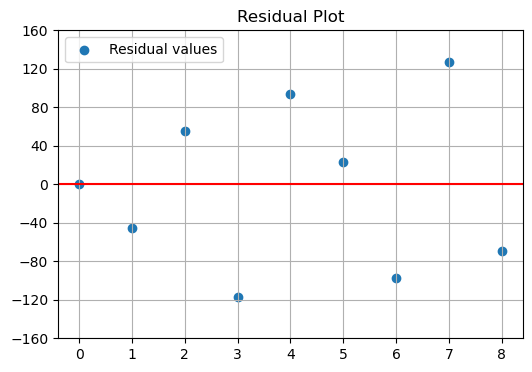

In [18]:
# Plotting the residuals
plt.figure(figsize=(6,4))
plt.scatter(np.arange(len(Fy)),residuals_2, label='Residual values')
plt.axhline(y=0, color='r')
plt.title('Residual Plot')
plt.yticks(np.arange(-160,180,40))
plt.legend()
plt.grid(True)
plt.savefig("Residual_Plot_Lateral_forces_vs_slip_angle.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
print(f'The Root Mean Squared Error is: {rmse:.3f}')
print(f'The Mean Absolute Percentage Error is: {100*mape:.3f}%')

The Root Mean Squared Error is: 80.786
The Mean Absolute Percentage Error is: 1.853%
